In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import talib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from LorentzianClassification.Classfier import LorentzianClassification

# Data Preparation

In [24]:
# List of currency pairs
currency_pairs = ["AUDUSD=X", "NZDUSD=X", "USDBRL=X", "USDCAD=X", "USDNOK=X", "USDZAR=X", 'USDJPY=X']

# Start & End Date
start_date = '2013-01-01'
end_date = '2023-01-01'

# Function to fetch exchange rate
def get_exchange_rate(currency_pairs ,start, end):
    price = yf.download(currency_pairs, start=start, end=end, group_by='ticker', interval='1d')
    return price

In [25]:
FX_df = get_exchange_rate(currency_pairs, start_date, end_date)

# Flatten MultiIndex columns
FX_df.columns = ['_'.join(col).strip() for col in FX_df.columns.values]

[*********************100%***********************]  7 of 7 completed


In [26]:
pair_dict = {}
for pair in currency_pairs:
    pair_data = FX_df[[col for col in FX_df.columns if col.startswith(pair)]]
    pair_data.columns = [col.split('_')[1] for col in pair_data.columns]  # Remove ticker from column names
    pair_data = pair_data.dropna()
    pair_dict[pair] = pair_data

In [27]:
currency_pairs

['AUDUSD=X',
 'NZDUSD=X',
 'USDBRL=X',
 'USDCAD=X',
 'USDNOK=X',
 'USDZAR=X',
 'USDJPY=X']

# Lorentzian Classification Predictions

In [63]:
lc = LorentzianClassification(pair_dict['USDCAD=X'])

lc = LorentzianClassification(
        pair_dict['NZDUSD=X'],
        features=[
            LorentzianClassification.Feature("RSI", 14, 2),  # f1
            LorentzianClassification.Feature("WT", 10, 11),  # f2
            LorentzianClassification.Feature("CCI", 20, 2),  # f3
            LorentzianClassification.Feature("ADX", 20, 2),  # f4
            LorentzianClassification.Feature("RSI", 9, 2),   # f5
        ],
        settings=LorentzianClassification.Settings(
            source=pair_dict['NZDUSD=X'].Close,
            neighborsCount=8,
            maxBarsBack=8000,
            useDynamicExits=False
        ),
        filterSettings=LorentzianClassification.FilterSettings(
            useVolatilityFilter=True,
            useRegimeFilter=True,
            useAdxFilter=False,
            regimeThreshold=-0.1,
            adxThreshold=20,
            kernelFilter = LorentzianClassification.KernelFilter(
                useKernelSmoothing = False,
                lookbackWindow = 8,
                relativeWeight = 8.0,
                regressionLevel = 25,
                crossoverLag = 1,
            )
        ))

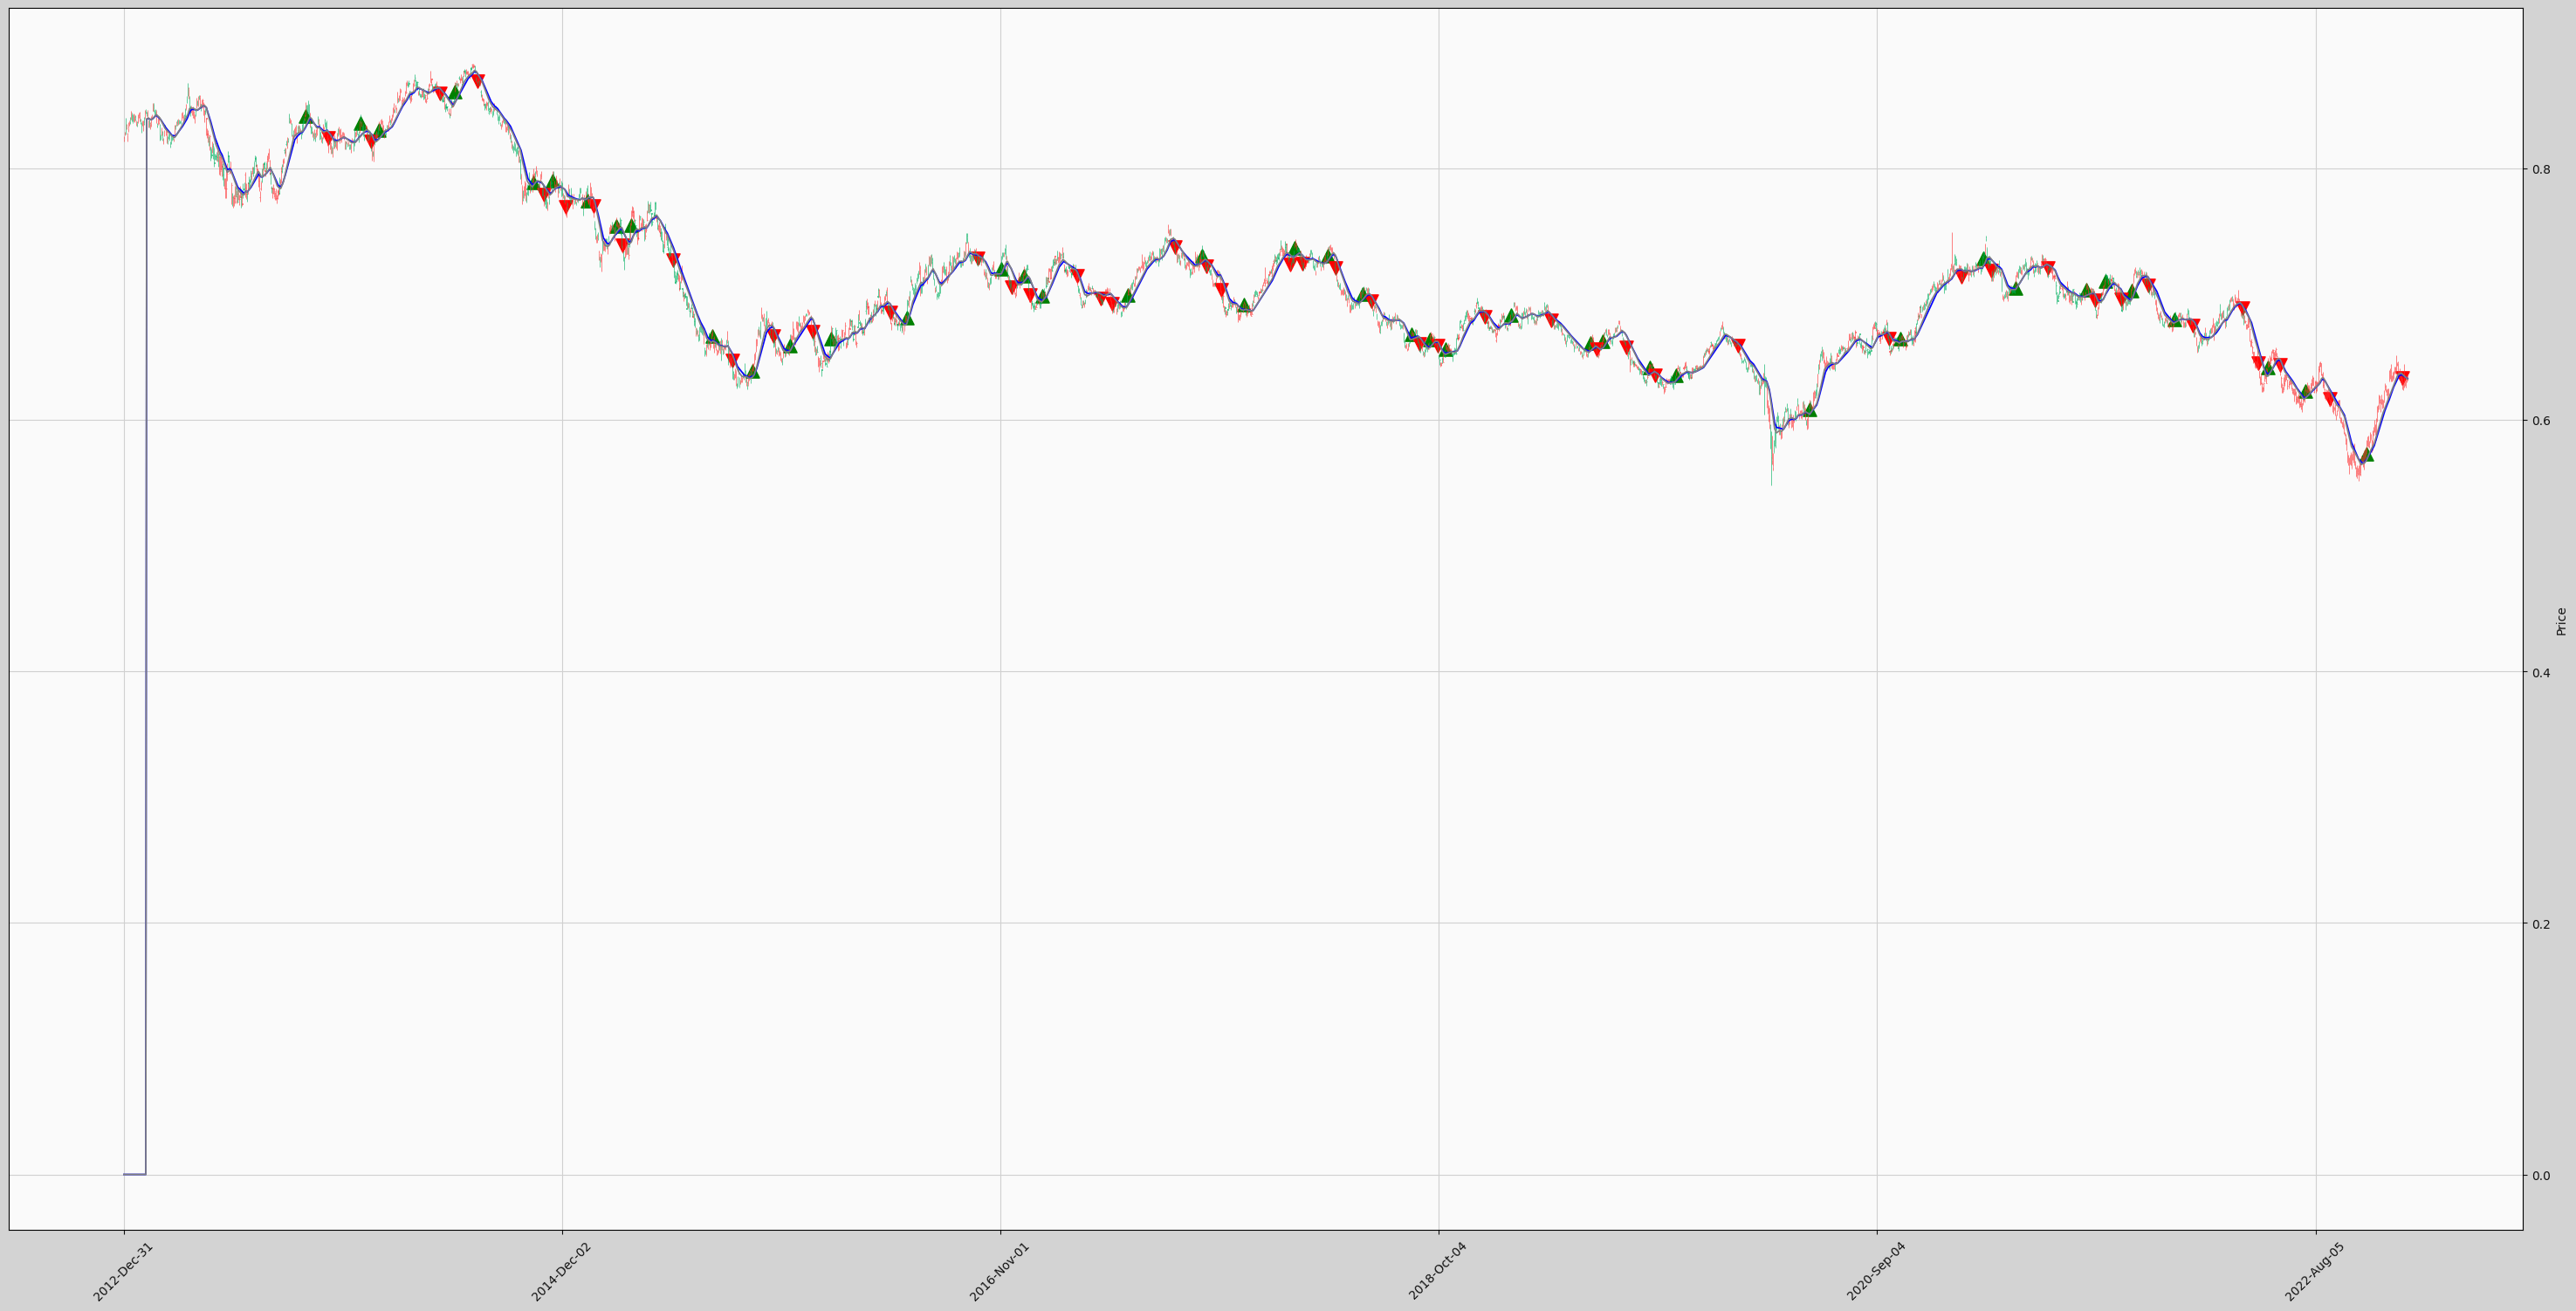

In [64]:
lc.plot()

# Backtesting

In [65]:
from backtesting import Backtest, Strategy

In [66]:
lc_df_all = lc.df.copy()
lc_df_all['yhat1'] = lc.yhat1

In [67]:
# Signals from LC model
def startLong():
    return lc_df_all.startLongTrade
def endLong():
    return lc_df_all.endLongTrade
def startShort():
    return lc_df_all.startShortTrade
def endShort():
    return lc_df_all.endShortTrade
def yhat1():
    return lc_df_all.yhat1

In [68]:
class LC_Hold4_Strategy(Strategy):
    def init(self):
        super().init()
        self.startlong = self.I(startLong)
        self.startshort = self.I(startShort)
        self.bars_since_buy_entry = 0
        self.bars_since_sell_entry = 0

    def next(self):
        super().next()
        if self.startlong > 0 :
            self.buy() # to add stop loss, use `sl` argument. Use `tp` for take profit
            self.bars_since_buy_entry = 0

        elif self.startshort > 0 :
            self.sell() # to add stop loss, use `sl` argument. Use `tp` for take profit
            self.bars_since_sell_entry = 0
        
        self.bars_since_buy_entry += 1
        self.bars_since_sell_entry +=1

        # Check if the number of bars since entry has reached 4
        if self.bars_since_buy_entry == 4 and self.position.is_long:
            self.position.close() 
        elif self.bars_since_sell_entry == 4 and self.position.is_short:
            self.position.close()  

In [76]:
bt_hold4 = Backtest(lc_df_all, LC_Hold4_Strategy, cash=10000, commission=0.002, trade_on_close=False)
stats_hold4 = bt_hold4.run()
stats_hold4

Start                     2012-12-31 00:00:00
End                       2022-12-30 00:00:00
Duration                   3651 days 00:00:00
Exposure Time [%]                   13.353799
Equity Final [$]                 12514.715355
Equity Peak [$]                  12657.499646
Return [%]                          25.147154
Buy & Hold Return [%]              -22.859203
Return (Ann.) [%]                    2.192871
Volatility (Ann.) [%]                3.068751
Sharpe Ratio                         0.714581
Sortino Ratio                        1.214342
Calmar Ratio                         0.415164
Max. Drawdown [%]                    -5.28194
Avg. Drawdown [%]                   -1.133147
Max. Drawdown Duration      357 days 00:00:00
Avg. Drawdown Duration       91 days 00:00:00
# Trades                                   87
Win Rate [%]                        56.321839
Best Trade [%]                       2.787993
Worst Trade [%]                     -2.150794
Avg. Trade [%]                    

In [77]:
bt_hold4.plot()

GridPlot(id='p3973', ...)

In [71]:
class LC_TurningPoint_Strategy(Strategy):
    def init(self):
        super().init()
        self.startlong = self.I(startLong)
        self.startshort = self.I(startShort)
        self.yhat1 = self.I(yhat1)
        self.grad = np.gradient(self.yhat1)
    def next(self):
        super().next()
        if self.startlong > 0 :
            self.buy() # to add stop loss, use `sl` argument. Use `tp` for take profit
        elif self.startshort > 0 :
            self.sell() # to add stop loss, use `sl` argument. Use `tp` for take profit
        
        
        # Check if the number of bars since entry has reached 4
        if self.grad[-1] < 0 and self.position.is_long:
            self.position.close() 
        elif self.grad[-1] > 0 and self.position.is_short:
            self.position.close()  

In [78]:
bt = Backtest(lc_df_all, LC_TurningPoint_Strategy, cash=10000, commission=0.002, trade_on_close=False)

In [79]:
stats = bt.run()
stats

Start                     2012-12-31 00:00:00
End                       2022-12-30 00:00:00
Duration                   3651 days 00:00:00
Exposure Time [%]                   56.216424
Equity Final [$]                  20057.22485
Equity Peak [$]                  20539.441824
Return [%]                         100.572248
Buy & Hold Return [%]              -22.859203
Return (Ann.) [%]                    6.962013
Volatility (Ann.) [%]                7.953047
Sharpe Ratio                         0.875389
Sortino Ratio                        1.435871
Calmar Ratio                         0.653681
Max. Drawdown [%]                  -10.650469
Avg. Drawdown [%]                   -1.625227
Max. Drawdown Duration      805 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                   87
Win Rate [%]                        49.425287
Best Trade [%]                      10.245682
Worst Trade [%]                      -2.13327
Avg. Trade [%]                    

In [80]:
bt.plot()

GridPlot(id='p4409', ...)

**Observations**
- model does not seem to work well in range-bound market --> is this an issue of tweaking the time ranges of the input variables?
- may need more conditions to achieve a better entry or exit point
- **TO VET**: To check if python implementation vs. original is correct. python implementation was copied over to another folder instead of pip install as there were errors with the implementation online. Check Classifier.py line 268 vs. original https://www.tradingview.com/script/WhBzgfDu-Machine-Learning-Lorentzian-Classification/ line 324. Model is supposed to predict direction in next 4 bars but the shifting from python implementation looks suspicious